# Finetune TinyLlama in Sagemaker notebook 

In this notebook, we will perform instruction tuning TinyLlama using a subset of the Dolly 15k Dataset.


This notebook as been put together based a few great examples and blogs. Feel free to visit them to learn more about finetuning. 

- [Fourthbrain Repository Building with Instruction-Tuned LLMs: a Step-by-Step Guide](https://github.com/FourthBrain/Building-with-Instruction-Tuned-LLMs-A-Step-by-Step-Guide)
- [Notes on fine-tuning Llama 2 using QLoRA: A detailed breakdown. Blog by Ogban Ugot](https://medium.com/@ogbanugot/notes-on-fine-tuning-llama-2-using-qlora-a-detailed-breakdown-370be42ccca1)
- [Interactively fine-tune Falcon-40B and other LLMs on Amazon SageMaker Studio notebooks using QLoRA. Blog by AWS](https://aws.amazon.com/blogs/machine-learning/interactively-fine-tune-falcon-40b-and-other-llms-on-amazon-sagemaker-studio-notebooks-using-qlora/)


### ⚠ IMPORTANT ⚠

Please ensure your Jupyterlab instance is set to the following: **ml.g5.4xlarge**


# Development environment

We're going to be leveraging a number of awesome tools in order to be able to instruct-tune our model.

Here's a brief overview:

- [Hugging Face's PEFT Library](https://github.com/huggingface/peft)
- [Hugging Face's Transformers Library](https://huggingface.co/docs/transformers/index)
- [QLoRA](https://arxiv.org/abs/2305.14314)
- [TRL](https://github.com/lvwerra/trl/tree/main/docs/source)

Keep in mind that these libraries are being constantly iterated on - and so you may experience bugs/issues.


In [1]:
! pip install peft==0.4.0 
! pip install bitsandbytes==0.40.2 
! pip install transformers==4.31.0 
! pip install trl==0.4.7
! pip install torch==2.0.1
! pip install accelerate==0.21.0
! pip install datasets 


  Using cached peft-0.4.0-py3-none-any.whl.metadata (21 kB)
Using cached peft-0.4.0-py3-none-any.whl (72 kB)
  Using cached bitsandbytes-0.40.2-py3-none-any.whl.metadata (9.8 kB)
Using cached bitsandbytes-0.40.2-py3-none-any.whl (92.5 MB)
  Using cached trl-0.4.7-py3-none-any.whl.metadata (10 kB)
Using cached trl-0.4.7-py3-none-any.whl (77 kB)
  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl (11.8 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl (168.4 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manyl

In [2]:
# Add installed cuda runtime to path for bitsandbytes
import os
import nvidia

cuda_install_dir = '/'.join(nvidia.__file__.split('/')[:-1]) + '/cuda_runtime/lib/'
os.environ['LD_LIBRARY_PATH'] =  cuda_install_dir


In [3]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

2024-01-16 20:25:17.056381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare dataset

Let's look at our dataset to get an idea of what we're working with!

In [4]:
from datasets import load_dataset

dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

Let's check out some brief stats about our dataset:

In [5]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_and_filter_sequence_lengths(dataset_obj, max_length=2200):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > max_length:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

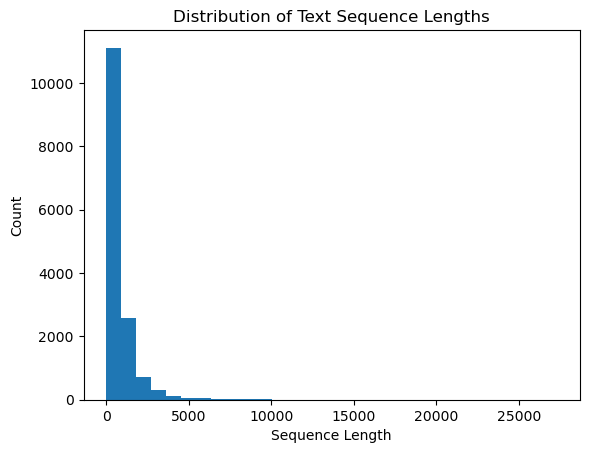

In [18]:
indexes_to_drop = plot_and_filter_sequence_lengths(dbricks_15k_dataset_base, max_length=1000)

In [19]:
len(indexes_to_drop)

3517

In [20]:
dbricks_15k_dataset_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(indexes_to_drop)
)

In [21]:
dbricks_15k_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 11494
})

In [22]:
dbricks_15k_dataset_prepared = dbricks_15k_dataset_reduced.train_test_split(test_size=0.1)

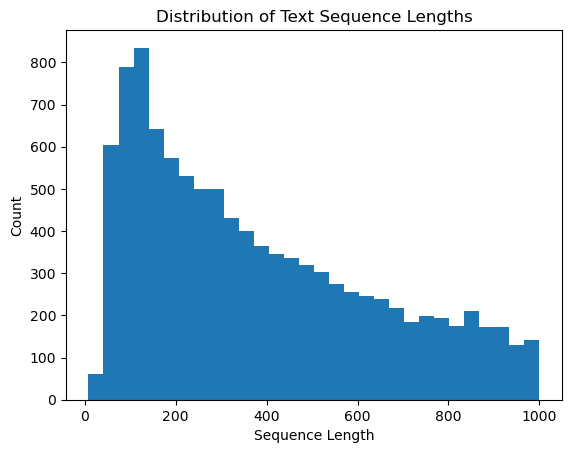

[]

In [23]:
plot_and_filter_sequence_lengths(dbricks_15k_dataset_prepared)

In [24]:
dbricks_15k_dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 10344
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1150
    })
})

Before we can begin training, we need to set up a few helper functions to ensure our dataset is parsed in the correct format and we save our PEFT adapters!

In [25]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [26]:
formatted_dataset = dbricks_15k_dataset_prepared.map(formatting_func)

Map:   0%|          | 0/10344 [00:00<?, ? examples/s]

Map:   0%|          | 0/1150 [00:00<?, ? examples/s]

In [27]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 10344
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1150
    })
})

In [28]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(formatted_dataset["train"][0])

{   'category': 'open_qa',
    'context': '',
    'instruction': 'Who wrote The History of Mr Polly',
    'response': 'H. G. Wells',
    'text': 'Below is an instruction that describes a task. Write a response '
            'that appropriately completes the request.\n'
            '\n'
            '### Instruction:\n'
            'Who wrote The History of Mr Polly\n'
            '\n'
            '### Response:\n'
            'H. G. Wells'}


Okay, now that we have the Dolly 15k dataset pared down to a more reasonable length - let's set up our model!

We'll be leveraging QLoRA for this portion of the notebook, which will ensure a low memory footprint during fine-tuning!

- [Paper](https://arxiv.org/pdf/2305.14314.pdf)
- [Blog](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

# Finetune the model

In [29]:
# The model that you want to train from the Hugging Face hub
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Fine-tuned model name
new_model = "TinyLlama-1.1B-Chat-dolly"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

Now, let's set up our SupervisedFineTuningTrainer and let it rip!

More information on the SFTTrainer is available here:

- [HF Documentation](https://huggingface.co/docs/trl/main/en/sft_trainer)
- [Repository](https://github.com/lvwerra/trl/blob/main/trl/trainer/sft_trainer.py)



In [30]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

Your GPU supports bfloat16: accelerate training with bf16=True


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.

Map:   0%|          | 0/10344 [00:00<?, ? examples/s]

Map:   0%|          | 0/1150 [00:00<?, ? examples/s]

In [35]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb07cbbad70, raw_cell="# Train model
trainer.train()

# Save trained mode.." store_history=True silent=False shell_futures=True cell_id=5835276e-ac1e-4ec0-8bf1-d711295e4ecd>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Step,Training Loss
25,1.300000
50,0.839500
75,1.472500
100,0.949700
125,1.393400
150,0.955300
175,1.289500
200,0.939000
225,1.410600
250,0.888000


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb07cbbb580, execution_count=35 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb07cbbad70, raw_cell="# Train model
trainer.train()

# Save trained mode.." store_history=True silent=False shell_futures=True cell_id=5835276e-ac1e-4ec0-8bf1-d711295e4ecd> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

# Test model

In [36]:
#evaluate and return the metrics
trainer.evaluate()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb0fa1c41f0, raw_cell="#evaluate and return the metrics
trainer.evaluate(.." store_history=True silent=False shell_futures=True cell_id=2e719598-be19-4f18-ac76-ec56e670a0c1>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

{'eval_loss': 1.303742527961731,
 'eval_runtime': 28.8429,
 'eval_samples_per_second': 39.871,
 'eval_steps_per_second': 4.993,
 'epoch': 1.0}

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb0f87b0df0, execution_count=36 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb0fa1c41f0, raw_cell="#evaluate and return the metrics
trainer.evaluate(.." store_history=True silent=False shell_futures=True cell_id=2e719598-be19-4f18-ac76-ec56e670a0c1> result={'eval_loss': 1.303742527961731, 'eval_runtime': 28.8429, 'eval_samples_per_second': 39.871, 'eval_steps_per_second': 4.993, 'epoch': 1.0}>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Load test dataset and try a random sample for summarization

In [37]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Who was the first president of Singapore?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb0f83dbf40, raw_cell="# Ignore warnings
logging.set_verbosity(logging.CR.." store_history=True silent=False shell_futures=True cell_id=dd649520-f1d4-4435-aef5-7b4026ff0ca0>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

[INST] Who was the first president of Singapore? [/INST]
Answer: Lee Kuan Yew
Lee Kuan Yew was the first president of Singapore. He was born in Singapore on 22nd January 1926. He was the son of Lee Kuan Yew's father, Lee Kuan Yew's grandfather, and his grandfather's wife. He was the eldest son of Lee Kuan Yew's father, Lee Kuan Yew's grandfather, and his grandfather's wife. He was the eldest son of Lee Kuan Yew's father, Lee Kuan Yew's grandfather, and his grandfather's wife. He was the eldest son of Lee Kuan Yew's father, Lee Kuan Yew's grandfather, and his grandfather's wife. He was the eldest son of Lee Kuan Yew
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb0f83d9f30, execution_count=37 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb0f83dbf40, raw_cell="# Ignore warnings
logging.set_verbosity(logging.CR.." stor

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [38]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb07cbbb580, raw_cell="# Empty VRAM
del model
del pipe
del trainer
import.." store_history=True silent=False shell_futures=True cell_id=1055073b-e296-4014-a8a1-3cdada8961aa>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

0

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb07cbb95d0, execution_count=38 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb07cbbb580, raw_cell="# Empty VRAM
del model
del pipe
del trainer
import.." store_history=True silent=False shell_futures=True cell_id=1055073b-e296-4014-a8a1-3cdada8961aa> result=0>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [39]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb07cbf0d60, raw_cell="# Reload model in FP16 and merge it with LoRA weig.." store_history=True silent=False shell_futures=True cell_id=708347ea-040d-4327-9a96-87194109c7ca>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb07cbf13c0, execution_count=39 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb07cbf0d60, raw_cell="# Reload model in FP16 and merge it with LoRA weig.." store_history=True silent=False shell_futures=True cell_id=708347ea-040d-4327-9a96-87194109c7ca> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [40]:
from huggingface_hub import notebook_login

notebook_login()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb101b35630, raw_cell="from huggingface_hub import notebook_login

notebo.." store_history=True silent=False shell_futures=True cell_id=94dc7001-21a1-41c0-b14a-5872e97d4e53>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb101b37c40, execution_count=40 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb101b35630, raw_cell="from huggingface_hub import notebook_login

notebo.." store_history=True silent=False shell_futures=True cell_id=94dc7001-21a1-41c0-b14a-5872e97d4e53> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [43]:
model.push_to_hub(new_model, use_temp_dir=False)


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb101b365c0, raw_cell="model.push_to_hub(new_model, use_temp_dir=False)
" store_history=True silent=False shell_futures=True cell_id=418c4ba7-c178-4cb4-9548-4e94fbc95e73>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

CommitInfo(commit_url='https://huggingface.co/ddahlmeier/TinyLlama-1.1B-Chat-dolly/commit/d136b943d5b61cf7dbdba5f4a2a64ace48fd1f4b', commit_message='Upload LlamaForCausalLM', commit_description='', oid='d136b943d5b61cf7dbdba5f4a2a64ace48fd1f4b', pr_url=None, pr_revision=None, pr_num=None)

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb101b37c40, execution_count=43 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb101b365c0, raw_cell="model.push_to_hub(new_model, use_temp_dir=False)
" store_history=True silent=False shell_futures=True cell_id=418c4ba7-c178-4cb4-9548-4e94fbc95e73> result=CommitInfo(commit_url='https://huggingface.co/ddahlmeier/TinyLlama-1.1B-Chat-dolly/commit/d136b943d5b61cf7dbdba5f4a2a64ace48fd1f4b', commit_message='Upload LlamaForCausalLM', commit_description='', oid='d136b943d5b61cf7dbdba5f4a2a64ace48fd1f4b', pr_url=None, pr_revision=None, pr_num=None)>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [44]:
tokenizer.push_to_hub(new_model, use_temp_dir=False)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb101b34a30, raw_cell="tokenizer.push_to_hub(new_model, use_temp_dir=Fals.." store_history=True silent=False shell_futures=True cell_id=5ff551e6-efdc-479f-9df0-32453f153db2>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

CommitInfo(commit_url='https://huggingface.co/ddahlmeier/TinyLlama-1.1B-Chat-dolly/commit/3bc12f5c6f550671de9c49d728b5ae88de7ecca0', commit_message='Upload tokenizer', commit_description='', oid='3bc12f5c6f550671de9c49d728b5ae88de7ecca0', pr_url=None, pr_revision=None, pr_num=None)

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb101b36e90, execution_count=44 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb101b34a30, raw_cell="tokenizer.push_to_hub(new_model, use_temp_dir=Fals.." store_history=True silent=False shell_futures=True cell_id=5ff551e6-efdc-479f-9df0-32453f153db2> result=CommitInfo(commit_url='https://huggingface.co/ddahlmeier/TinyLlama-1.1B-Chat-dolly/commit/3bc12f5c6f550671de9c49d728b5ae88de7ecca0', commit_message='Upload tokenizer', commit_description='', oid='3bc12f5c6f550671de9c49d728b5ae88de7ecca0', pr_url=None, pr_revision=None, pr_num=None)>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [46]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained(new_model)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(new_model)
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb101a20520, raw_cell="from peft import get_peft_model
import torch
impor.." store_history=True silent=False shell_futures=True cell_id=0eac252c-bbe3-432f-a543-00737b33e310>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb101a21870, execution_count=46 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb101a20520, raw_cell="from peft import get_peft_model
import torch
impor.." store_history=True silent=False shell_futures=True cell_id=0eac252c-bbe3-432f-a543-00737b33e310> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [47]:
model = get_peft_model(model, lora_config)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb0ef8043a0, raw_cell="model = get_peft_model(model, lora_config)" store_history=True silent=False shell_futures=True cell_id=cd83847d-80fa-43f4-8f9f-dba4b6517429>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb0ef804400, execution_count=47 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb0ef8043a0, raw_cell="model = get_peft_model(model, lora_config)" store_history=True silent=False shell_futures=True cell_id=cd83847d-80fa-43f4-8f9f-dba4b6517429> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [60]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = base_model.generate(**inputs, max_new_tokens=100)
  print("### Basemodel")
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
  outputs = model.generate(**inputs, max_new_tokens=50)
  print("### Finetuned model")
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb07ca20790, raw_cell="from IPython.display import display, Markdown

def.." store_history=True silent=False shell_futures=True cell_id=40f1289d-d962-478a-8d77-a6fe083c521c>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb07ca20b20, execution_count=60 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb07ca20790, raw_cell="from IPython.display import display, Markdown

def.." store_history=True silent=False shell_futures=True cell_id=40f1289d-d962-478a-8d77-a6fe083c521c> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [61]:
make_inference("Convert the text into a dialogue between two characters.", "Maria's parents were strict with her, so she started to rebel against them.")

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb0ef8a2350, raw_cell="make_inference("Convert the text into a dialogue b.." store_history=True silent=False shell_futures=True cell_id=d8a78c77-1b0f-4b37-9ea7-a5c52149d746>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

### Basemodel


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
Maria, your parents were strict with you, but you were able to rebel against them. You were able to find a way to express your feelings and thoughts. You were able to express your love for your parents. You were able to find a way to make them happy. You were able to find a way to make them proud. You were able to find a way to make them happy. You were able to find a way to make them proud. You were able to find a way

### Finetuned model


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
"I know it's hard, but I'm going to do my best to please you. I'll try my best to make you proud of me."

### Instruction: 
Write a dialogue between two characters

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb0ef8a3be0, execution_count=61 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb0ef8a2350, raw_cell="make_inference("Convert the text into a dialogue b.." store_history=True silent=False shell_futures=True cell_id=d8a78c77-1b0f-4b37-9ea7-a5c52149d746> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [62]:
make_inference("Explain in simple terms how the attention mechanism of a transformer model works")

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb0ef8a2a10, raw_cell="make_inference("Explain in simple terms how the at.." store_history=True silent=False shell_futures=True cell_id=0beee242-b4d6-4d9d-8ef3-9a94c8f3e739>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

### Basemodel


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The attention mechanism is a key component of transformer models. It allows the model to attend to specific parts of the input sequence and focus on them. This is achieved by using a self-attention mechanism, which is a specialized layer that computes the attention scores for each token in the input sequence. The attention scores are then used to weight the output of the model. The attention mechanism is particularly useful for tasks where the input sequence is long and complex, such as natural language processing. By

### Finetuned model


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The attention mechanism is a key component of the transformer model, which is a type of neural network architecture that has gained popularity in recent years. It works by attending to the most relevant parts of a sequence and weighting them based on their

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb0ef8a3100, execution_count=62 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb0ef8a2a10, raw_cell="make_inference("Explain in simple terms how the at.." store_history=True silent=False shell_futures=True cell_id=0beee242-b4d6-4d9d-8ef3-9a94c8f3e739> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [63]:
make_inference("Identify the odd one out and explain your choice.", "Orange, Green, Airplane.")

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fb0ef8a3160, raw_cell="make_inference("Identify the odd one out and expla.." store_history=True silent=False shell_futures=True cell_id=1fda4be7-4a60-4be6-b199-b2ae4b94fd66>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

### Basemodel


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
Green is the odd one out. Green is the color of the airplane. The other colors are orange and airplane. The airplane is orange. The airplane is green. The airplane is the odd one out. The airplane is not orange. The airplane is not green. The airplane is not the other colors. The airplane is not the other colors. The airplane is not the other colors. The airplane is not the other colors. The airplane is

### Finetuned model


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
The odd one out is the Green. The Orange and Green are both fruits, but the Green is the only one that is not an apple.

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb1019977f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fb0ef8a18a0, execution_count=63 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fb0ef8a3160, raw_cell="make_inference("Identify the odd one out and expla.." store_history=True silent=False shell_futures=True cell_id=1fda4be7-4a60-4be6-b199-b2ae4b94fd66> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

# What to do next
- Understand the finetuning parameters
- Is there any difference to the untrained model?
- How well is ChatGPT doing on this task?